### Description

This notebook shows techniques for evaluating the results of a prediction with a Machine Learning algorithm.

### Imports

In [1]:
from scipy.io import arff
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin

/home/alvaro/snap/jupyter/common/lib/python3.7/site-packages/joblib/_multiprocessing_helpers.py:45: UserWarning: [Errno 13] Permission denied.  joblib will operate in serial mode
  warnings.warn('%s.  joblib will operate in serial mode' % (e,))


### Auxiliary functions

In [2]:
def load_kdd_dataset(data_path):
    data, meta = arff.loadarff(data_path)
    df = pd.DataFrame(data, columns = meta)
    x_columns = df.select_dtypes(include=['object']).columns
    for i in x_columns:
        df[i] = df[i].str.decode('utf-8') 
    return df

In [3]:
def train_val_test_split(df, rstate=42, shuffle=True, stratify=None):
    strat = df[stratify] if stratify else None
    train_set, test_set = train_test_split(
        df, test_size=0.4, random_state=rstate, shuffle=shuffle, stratify=strat)
    strat = test_set[stratify] if stratify else None
    val_set, test_set = train_test_split(
        test_set, test_size=0.5, random_state=rstate, shuffle=shuffle, stratify=strat)
    return (train_set, val_set, test_set)

In [4]:
# Create a pipeline for numeric attributes
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('rbst_scaler', RobustScaler()),
    ])

In [5]:
# Transformer to modify only the categorical columns and return a df
class CustomOneHotEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self._oh = OneHotEncoder(sparse=False)
        self._columns = None
    def fit(self, X, y=None):
        X_cat = X.select_dtypes(include=['object'])
        self._columns = pd.get_dummies(X_cat).columns
        self._oh.fit(X_cat)
        return self
    def transform(self, X, y=None):
        X_copy = X.copy()
        X_cat = X_copy.select_dtypes(include=['object'])
        X_num = X_copy.select_dtypes(exclude=['object'])
        X_cat_oh = self._oh.transform(X_cat)
        X_cat_oh = pd.DataFrame(X_cat_oh, 
                                columns=self._columns, 
                                index=X_copy.index)
        X_copy.drop(list(X_cat), axis=1, inplace=True)
        return X_copy.join(X_cat_oh)

In [6]:
# Transformer that prepares the entire dataset by calling pipelines and custom transformers
class DataFramePreparer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self._full_pipeline = None
        self._columns = None
    def fit(self, X, y=None):
        num_attribs = list(X.select_dtypes(exclude=['object']))
        cat_attribs = list(X.select_dtypes(include=['object']))
        self._full_pipeline = ColumnTransformer([
                ("num", num_pipeline, num_attribs),
                ("cat", CustomOneHotEncoder(), cat_attribs),
        ])
        self._full_pipeline.fit(X)
        self._columns = pd.get_dummies(X).columns
        return self
    def transform(self, X, y=None):
        X_copy = X.copy()
        X_prep = self._full_pipeline.transform(X_copy)
        return pd.DataFrame(X_prep, 
                            columns=self._columns, 
                            index=X_copy.index)

### Reading the data set

In [7]:
df = load_kdd_dataset("../datasets/NSL-KDD/KDDTrain+.arff")

In [8]:
df

'KDDTrain',duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0.0,tcp,ftp_data,SF,491.0,0.0,0,0.0,0.0,0.0,...,25.0,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0.0,udp,other,SF,146.0,0.0,0,0.0,0.0,0.0,...,1.0,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0.0,tcp,private,S0,0.0,0.0,0,0.0,0.0,0.0,...,26.0,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,anomaly
3,0.0,tcp,http,SF,232.0,8153.0,0,0.0,0.0,0.0,...,255.0,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0.0,tcp,http,SF,199.0,420.0,0,0.0,0.0,0.0,...,255.0,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125968,0.0,tcp,private,S0,0.0,0.0,0,0.0,0.0,0.0,...,25.0,0.10,0.06,0.00,0.00,1.00,1.00,0.00,0.00,anomaly
125969,8.0,udp,private,SF,105.0,145.0,0,0.0,0.0,0.0,...,244.0,0.96,0.01,0.01,0.00,0.00,0.00,0.00,0.00,normal
125970,0.0,tcp,smtp,SF,2231.0,384.0,0,0.0,0.0,0.0,...,30.0,0.12,0.06,0.00,0.00,0.72,0.00,0.01,0.00,normal
125971,0.0,tcp,klogin,S0,0.0,0.0,0,0.0,0.0,0.0,...,8.0,0.03,0.05,0.00,0.00,1.00,1.00,0.00,0.00,anomaly


### Splitting of the data set

In [9]:
train_set, val_set, test_set = train_val_test_split(df)

In [10]:
print("Training Set Length:", len(train_set))
print("Validation Set Length:", len(val_set))
print("Test Set Length:", len(test_set))

Longitud del Training Set: 75583
Longitud del Validation Set: 25195
Longitud del Test Set: 25195


For each of the subsets, we separate the labels from the input features.

In [11]:
# Overall dataset
X_df = df.drop("class", axis=1)
y_df = df["class"].copy()

In [12]:
# Training dataset
X_train = train_set.drop("class", axis=1)
y_train = train_set["class"].copy()

In [13]:
# Validation dataset
X_val = val_set.drop("class", axis=1)
y_val = val_set["class"].copy()

In [14]:
# test dataset
X_test = test_set.drop("class", axis=1)
y_test = test_set["class"].copy()

### Dataset preparation

In [15]:
# Instantiate our custom transformer
data_preparer = DataFramePreparer()

In [16]:
# We apply the fit with the general data set so that it acquires all possible values
data_preparer.fit(X_df)

DataFramePreparer()

In [17]:
# We transform the training data subset
X_train_prep = data_preparer.transform(X_train)

In [18]:
X_train.head(5)

'KDDTrain',duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
98320,0.0,icmp,ecr_i,SF,1032.0,0.0,0,0.0,0.0,0.0,...,210.0,65.0,0.31,0.01,0.31,0.00,0.0,0.0,0.0,0.0
8590,0.0,tcp,smtp,SF,1762.0,331.0,0,0.0,0.0,0.0,...,30.0,122.0,0.73,0.07,0.03,0.02,0.0,0.0,0.0,0.0
91385,0.0,icmp,eco_i,SF,8.0,0.0,0,0.0,0.0,0.0,...,2.0,126.0,1.00,0.00,1.00,0.25,0.0,0.0,0.0,0.0
54349,0.0,tcp,csnet_ns,S0,0.0,0.0,0,0.0,0.0,0.0,...,255.0,18.0,0.07,0.07,0.00,0.00,1.0,1.0,0.0,0.0
69568,0.0,tcp,smtp,SF,1518.0,342.0,0,0.0,0.0,0.0,...,83.0,125.0,0.66,0.05,0.01,0.02,0.0,0.0,0.0,0.0


In [19]:
X_train_prep.head(5)

,duration,src_bytes,dst_bytes,wrong_fragment,urgent,hot,num_failed_logins,num_compromised,root_shell,su_attempted,...,flag_SF,flag_SH,land_0,land_1,logged_in_0,logged_in_1,is_host_login_0,is_host_login_1,is_guest_login_0,is_guest_login_1
98320,0.0,3.579710,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
8590,0.0,6.224638,0.641473,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
91385,0.0,-0.130435,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
54349,0.0,-0.159420,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
69568,0.0,5.340580,0.662791,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0


In [20]:
# We transform the validation data subset
X_val_prep = data_preparer.transform(X_val)

## Training of a Logistic Regression algorithm

Instantiating a Machine Learning algorithm using Sklearn is done using the methods exposed by the sklearn API as presented in previous notebooks.

In [21]:
# We train an algorithm based on logistic regression
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(max_iter=5000)
clf.fit(X_train_prep, y_train)

/home/alvaro/snap/jupyter/common/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(max_iter=5000)

### Prediction of new examples

In [22]:
# We make a prediction with the previously generated model after training the Logistic Regression algorithm. We use the validation subset.
y_pred = clf.predict(X_val_prep)

## 1. Confusion Matrix

In [23]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_val, y_pred)

array([[11400,   474],
       [  245, 13076]])

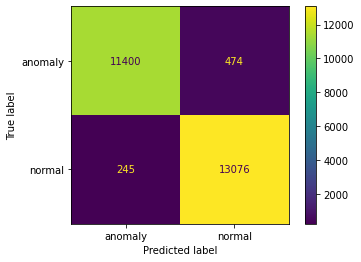

In [27]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(clf, X_val_prep, y_val, values_format='3g')

In [51]:
X_cat3 = df.select_dtypes(include=['object'])
X_cat3

'KDDTrain',protocol_type,service,flag,land,logged_in,is_host_login,is_guest_login,class
0,tcp,ftp_data,SF,0,0,0,0,normal
1,udp,other,SF,0,0,0,0,normal
2,tcp,private,S0,0,0,0,0,anomaly
3,tcp,http,SF,0,1,0,0,normal
4,tcp,http,SF,0,1,0,0,normal
...,...,...,...,...,...,...,...,...
125968,tcp,private,S0,0,0,0,0,anomaly
125969,udp,private,SF,0,0,0,0,normal
125970,tcp,smtp,SF,0,1,0,0,normal
125971,tcp,klogin,S0,0,0,0,0,anomaly


In [52]:
# Se obtiene un arreglo con todos los tipos de datos (todas las categorias) 
# que tiene cada columna.
# Por ejemplo, 'protocol_type' solo tiene 3: TCP, ICMP, UDP.
dummies2 = pd.get_dummies(X_cat3).columns